In [1]:
import voxelmorph2d as vm2d
import voxelmorph3d as vm3d

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
import multiprocessing as mp
from tqdm import tqdm
import gc
import time
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
import glob
import os
from dataset import DataSet
import warnings

In [3]:
import myn2

In [4]:
import cv2
import math
from PIL import Image
from torch.optim import lr_scheduler

In [56]:
def get_data(fixed_path,moving_path,label_path):
    train_files_moving = glob.glob(os.path.join(moving_path, '*.dcm'))
    train_files_fixed = glob.glob(os.path.join(fixed_path, "*.dcm"))
    train_files_moving.sort()
    train_files_fixed.sort()

    DS1 = DataSet(train_files_moving)
    DS2 = DataSet(train_files_fixed)
    print("Number of training moving images: ", len(DS1))
    print("Number of training fixed images: ", len(DS2))
    moving_list = []
    fixed_list = []
    for i in range(383):
        moving_list.append(DS1[i])
        fixed_list.append(DS2[i])
        
    for i in range(383):
        c=moving_list[i].cpu().detach().numpy()
        m=c.max()
        l=c.min()
        moving_list[i]=(moving_list[i]-torch.tensor(l))/(m-l)*255

    for i in range(383):
        c=fixed_list[i].cpu().detach().numpy()
        m=c.max()
        l=c.min()
        fixed_list[i]=(fixed_list[i]-torch.tensor(l))/(m-l)*255

    moving_list1 = torch.tensor([item.cpu().detach().numpy() for item in moving_list])
    fixed_list1 = torch.tensor([item.cpu().detach().numpy() for item in fixed_list])
    
    df = pd.read_excel(label_path)
    
    warnings.filterwarnings("ignore")
    label_list=[]
    for x in train_files_moving:
        txt=x.split("/")[2]
        patient=int(txt.split("(")[0])
        p=txt.split("(")[1]
        slicer=int(p[0])
#     print(patient,"  ",slicer)
        label=df[df["病人"]==patient][df["slice"]==slicer]["label"]
        if(label.item()>=0.5):
            label_list.append(0)
        else:
            label_list.append(1)
    label_list=np.array(label_list)
    label_list_ten=torch.tensor(label_list)
    
#     print(len(moving_list))
    custom_dataset = data.TensorDataset(moving_list1,fixed_list1,label_list_ten)
    have_motion_moving  = []
    have_motion_fix = []
    no_motion_fix = []
    no_motion_moving = []
    
    for moving,fixed,target in custom_dataset:
        if(target.item()==1):
            no_motion_moving.append(moving)
            no_motion_fix.append(fixed)
        else:
            have_motion_moving.append(moving)
            have_motion_fix.append(fixed)
    have_motion_fix=torch.tensor([item.cpu().detach().numpy() for item in have_motion_fix])
    have_motion_moving=torch.tensor([item.cpu().detach().numpy() for item in have_motion_moving])
    no_motion_fix=torch.tensor([item.cpu().detach().numpy() for item in no_motion_fix])
    no_motion_moving=torch.tensor([item.cpu().detach().numpy() for item in no_motion_moving])

    motion = data.TensorDataset(have_motion_moving,have_motion_fix)
    no_motion = data.TensorDataset(no_motion_moving,no_motion_fix)

    m_generator = data.DataLoader(motion, batch_size=32, shuffle=True)

    #     validation_set = data.TensorDataset(moving_list1[306:383],fixed_list1[306:383],label_list_ten[306:383])
    nm_generator = data.DataLoader(no_motion, batch_size=32, shuffle=True)
    
    return m_generator,nm_generator,motion,no_motion

In [57]:
motion,no_motion,motion_set,no_motion_set=get_data("./fixed","./moving","./label_filtered.xls")

Number of training moving images:  383
Number of training fixed images:  383


In [30]:
def getdata(fixed_path,moving_path,label_path):
    train_files_moving = glob.glob(os.path.join(moving_path, '*.dcm'))
    train_files_fixed = glob.glob(os.path.join(fixed_path, "*.dcm"))
    train_files_moving.sort()
    train_files_fixed.sort()

    DS1 = DataSet(train_files_moving)
    DS2 = DataSet(train_files_fixed)
    print("Number of training moving images: ", len(DS1))
    print("Number of training fixed images: ", len(DS2))
    moving_list = []
    fixed_list = []
    for i in range(383):
        moving_list.append(DS1[i])
        fixed_list.append(DS2[i])
        
    for i in range(383):
        c=moving_list[i].cpu().detach().numpy()
        m=c.max()
        l=c.min()
        moving_list[i]=(moving_list[i]-torch.tensor(l))/(m-l)*255

    for i in range(383):
        c=fixed_list[i].cpu().detach().numpy()
        m=c.max()
        l=c.min()
        fixed_list[i]=(fixed_list[i]-torch.tensor(l))/(m-l)*255

    moving_list1 = torch.tensor([item.cpu().detach().numpy() for item in moving_list])
    fixed_list1 = torch.tensor([item.cpu().detach().numpy() for item in fixed_list])
    
    df = pd.read_excel(label_path)
    
    warnings.filterwarnings("ignore")
    label_list=[]
    for x in train_files_moving:
        txt=x.split("/")[2]
        patient=int(txt.split("(")[0])
        p=txt.split("(")[1]
        slicer=int(p[0])
#     print(patient,"  ",slicer)
        label=df[df["病人"]==patient][df["slice"]==slicer]["label"]
        if(label.item()>=0.5):
            label_list.append(0)
        else:
            label_list.append(1)
    label_list=np.array(label_list)
    label_list_ten=torch.tensor(label_list)
    
#     print(len(moving_list))
    custom_dataset = data.TensorDataset(moving_list1,fixed_list1,label_list_ten)
    train_size = int(len(custom_dataset) * 0.8)
    test_size = len(custom_dataset) - train_size
    training_set, validation_set = torch.utils.data.random_split(custom_dataset, [train_size, test_size],generator=torch.Generator().manual_seed(0))
#     training_set = data.TensorDataset(moving_list1[0:306],fixed_list1[0:306],label_list_ten[0:306])
    training_generator = data.DataLoader(training_set, batch_size=32, shuffle=True)

#     validation_set = data.TensorDataset(moving_list1[306:383],fixed_list1[306:383],label_list_ten[306:383])
    validation_generator = data.DataLoader(validation_set, batch_size=1, shuffle=True)
    
    return training_set,training_generator,validation_set,validation_generator

In [27]:
class VoxelMorph():
    """
    VoxelMorph Class is a higher level interface for both 2D and 3D
    Voxelmorph classes. It makes training easier and is scalable.
    """

    def __init__(self, input_dims, is_2d=False, use_gpu=False):
        self.dims = input_dims
        if is_2d:
            self.vm = vm2d
            self.voxelmorph = vm2d.VoxelMorph2d(input_dims[0] * 2, use_gpu)
        else:
            self.vm = vm3d
            self.voxelmorph = vm3d.VoxelMorph3d(input_dims[0] * 2, use_gpu)
        self.optimizer = optim.SGD(self.voxelmorph.parameters(), lr=1e-4, momentum=0.99)
        self.params = {'batch_size': 3,
                       'shuffle': True,
                       'num_workers': 6,
                       'worker_init_fn': np.random.seed(42)
                       }
        self.device = torch.device("cuda:0" if use_gpu else "cpu")

    def check_dims(self, x):
        try:
            if x.shape[1:] == self.dims:
                return
            else:
                raise TypeError
        except TypeError as e:
            print("Invalid Dimension Error. The supposed dimension is ",
                  self.dims, "But the dimension of the input is ", x.shape[1:])

    def forward(self, x):
        self.check_dims(x)
        return voxelmorph(x)

    def calculate_loss(self, y, ytrue, n=9, lamda=0.01, is_training=True):
        loss = self.vm.vox_morph_loss(y, ytrue, n, lamda)
        return loss

    def train_model(self, batch_moving, batch_fixed, n=9, lamda=0.01, return_metric_score=True):
        self.optimizer.zero_grad()
        batch_fixed, batch_moving = batch_fixed.to(self.device), batch_moving.to(self.device)
        registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
        print(batch_fixed.shape)
        train_loss = self.calculate_loss(registered_image, batch_fixed, n, lamda)
        train_loss.backward()
        self.optimizer.step()
        if return_metric_score:
            train_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return train_loss, train_dice_score
        return train_loss

    def get_test_loss(self, batch_moving, batch_fixed, n=9, lamda=0.01):
        with torch.set_grad_enabled(False):
            registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
            val_loss = self.vm.vox_morph_loss(registered_image, batch_fixed, n, lamda)
            val_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return val_loss, val_dice_score

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
training_set,training_generator,validation_set,validation_generator=getdata("./fixed","./moving","./label_filtered.xls")

Number of training moving images:  383
Number of training fixed images:  383


In [83]:
def test(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for moving,fixed,target in validation_generator:
#             mini_batch = moving.shape[0]
#             target = torch.ones(mini_batch).cuda().float()
            inputs=torch.cat([moving, fixed], dim=1)
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            _, prediction = torch.max(outputs.data, dim=1)

            total += target.size(0)
            correct += (prediction == target).sum().item()
        print('Accuracy on test set: (%d/%d)%d %%' % (correct, total, 100 * correct / total))

In [84]:
def test_train(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for moving,fixed,target in training_generator:
            inputs=torch.cat([moving, fixed], dim=1)
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            _, prediction = torch.max(outputs.data, dim=1)

            total += target.size(0)
            correct += (prediction == target).sum().item()
        print('Accuracy on train set: (%d/%d)%d %%' % (correct, total, 100 * correct / total))

In [92]:
def test_generator(D,G):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for moving,fixed,_ in training_generator:
            mini_batch = moving.shape[0]
            g_label = torch.ones(mini_batch).cuda().float()
            fixed = fixed.cuda().float()
            batch_fixed_reorder = fixed.permute(0, 3, 2, 1).cuda().float()
            batch_moving_reorder = moving.permute(0, 3, 2, 1).cuda().float()
            dat_fake, deformation = G(batch_moving_reorder, batch_fixed_reorder)
            dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)
            inputs=torch.cat([dat_fake_reorder, fixed], dim=1)
            inputs = inputs.to(device)
            outputs = D(inputs)
            _, prediction = torch.max(outputs.data, dim=1)

            total += mini_batch
            correct += (prediction == g_label).sum().item()
        print('Accuracy on generator train_set: (%d/%d)%d %%' % (correct, total, 100 * correct / total))
        return correct

In [114]:
D=myn2.MyNet().to(device)

In [115]:
vm = VoxelMorph((1, 256, 256), is_2d=True,  use_gpu=True)  # Obje
# ct of the higher level class
generator = vm.voxelmorph
G=generator.to(device)

In [116]:
lr_g = 2e-4
lr_d = 2e-6

D_losses = []
G_losses = []
G_losses_total = []

G_optimizer = optim.Adam(G.parameters(), lr=lr_g, betas=(.5, 0.999))
G_scheduler = lr_scheduler.StepLR(G_optimizer,step_size=80,gamma=0.1)
# D_optimizer = optim.Adam(D.parameters(), lr=lr_d, betas=(.5, 0.999))
D_optimizer = optim.SGD(D.parameters(), lr=lr_d,momentum=0.9)
# D_scheduler = lr_scheduler.StepLR(G_optimizer,step_size=100,gamma=0.1)

In [117]:
BCELoss = nn.BCELoss()
MSELoss = nn.MSELoss()
KLDiveLoss = nn.KLDivLoss()

loss_fnc=nn.CrossEntropyLoss()
SmoothingLoss = vm2d.smooothing_loss

In [118]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./logs')

In [119]:
epochs = 201
train_interval = 7
max_acc=0
now_acc=0
for epoch in range(1,epochs):
    test(D)
    test_train(D)
    now_acc = test_generator(D,G)
    for batch_moving, batch_fixed,label in training_generator:

        mini_batch = batch_moving.shape[0]

        y_fake=torch.zeros(mini_batch)
        y_real=torch.ones(mini_batch)
        if True:
            batch_moving = batch_moving.cuda().float()
            batch_fixed = batch_fixed.cuda().float()
            label = label.cuda()
            y_fake=y_fake.cuda()
            y_real=y_real.cuda()

        batch_fixed_reorder = batch_fixed.permute(0, 3, 2, 1)
        batch_moving_reorder = batch_moving.permute(0, 3, 2, 1)
        
        # Train discriminator D
        D.zero_grad()
        features=torch.cat([batch_moving, batch_fixed], dim=1)
        D_real = D(features)# 将真实图像对放入判别器中进行训练

        D_real_loss = loss_fnc(D_real, label)## 得到真实图像对的loss
#         D_real_loss.backward()


#         D_optimizer.step()
         ## 计算假的图像对的损失
        with torch.no_grad():
            dat_fake, _ = G(batch_moving_reorder, batch_fixed_reorder)
        dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)

        D_fake = D(torch.cat([dat_fake_reorder,batch_fixed],dim=1))
        D_fake_loss = loss_fnc(D_fake, label)# 得到假的图像对的损失，D_fake越接近1越好
#         D_fake_loss.backward()

        
        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        D_optimizer.step()
        D_losses.append(D_train_loss.data.item())

        # Train generator G
        for iter in range(train_interval):
            
            G.zero_grad()
            dat_fake, deformation = G(batch_moving_reorder, batch_fixed_reorder)
            dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)
            
            
            with torch.no_grad():
                D_fake = D(torch.cat([dat_fake_reorder, batch_fixed], dim=1))
#             print(y_fake)
            G_train_loss = loss_fnc(D_fake,y_real.long())
#             print(G_train_loss)
#             print(MSELoss(dat_fake, batch_fixed).item())
#             print(SmoothingLoss(dat_fake).item())
            G_train_loss_total = G_train_loss + 0.02*SmoothingLoss(dat_fake)

            G_train_loss_total.backward()
            G_optimizer.step()
            G_losses.append(G_train_loss.data.item())
            G_losses_total.append(G_train_loss_total.data.item())

    print('[%d/%d], loss_D: %.3f,loss_g: %.3f, loss_g_total: %.3f' % ((epoch), epochs,
                                                    torch.mean(torch.FloatTensor(D_losses)),
                                                    torch.mean(torch.FloatTensor(G_losses)),
                                                    torch.mean(torch.FloatTensor(G_losses_total))))
    G_scheduler.step()
    if(max_acc<now_acc):
        torch.save({'model': G.state_dict()}, '_G_best_CrossEn_5_3.pth')
        max_acc=now_acc
    if(epoch%20==0):
        torch.save({'model': G.state_dict()}, str(epoch)+'_G_new_CrossEn_5_3.pth')
        print("Save model successfully")
    writer.add_scalars("loss", {'D_loss': torch.mean(torch.FloatTensor(D_losses)), 'G_loss': torch.mean(torch.FloatTensor(G_losses_total))}, epoch)

Accuracy on test set: (38/77)49 %
Accuracy on train set: (133/306)43 %
Accuracy on generator train_set: (257/306)83 %
[1/201], loss_D: 1.420,loss_g: 0.717, loss_g_total: 0.882
Accuracy on test set: (41/77)53 %
Accuracy on train set: (189/306)61 %
Accuracy on generator train_set: (64/306)20 %
[2/201], loss_D: 1.393,loss_g: 0.856, loss_g_total: 1.007
Accuracy on test set: (40/77)51 %
Accuracy on train set: (191/306)62 %
Accuracy on generator train_set: (26/306)8 %
[3/201], loss_D: 1.378,loss_g: 0.888, loss_g_total: 1.032
Accuracy on test set: (42/77)54 %
Accuracy on train set: (199/306)65 %
Accuracy on generator train_set: (50/306)16 %
[4/201], loss_D: 1.365,loss_g: 0.891, loss_g_total: 1.032
Accuracy on test set: (44/77)57 %
Accuracy on train set: (199/306)65 %
Accuracy on generator train_set: (59/306)19 %
[5/201], loss_D: 1.355,loss_g: 0.887, loss_g_total: 1.025
Accuracy on test set: (43/77)55 %
Accuracy on train set: (200/306)65 %
Accuracy on generator train_set: (53/306)17 %
[6/201],

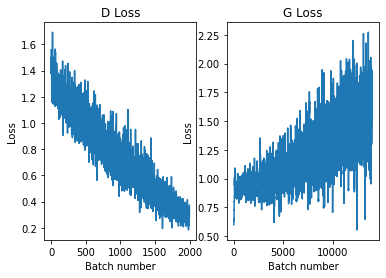

In [120]:
#Plotting:

#Losses:
plt.subplot(1, 2, 1)
plt.plot(D_losses)
plt.title("D Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses)
plt.title("G Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss");

In [10]:
model = generator.to(device)
state_dict = torch.load('100_G_new_CrossEn3.pth')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [122]:
def savebin(arr,name):
    gray_arr = (arr - arr.min()) * 255 / (arr.max() - arr.min())
    gray_arr = gray_arr.astype('uint8')
    gray_img = Image.fromarray(gray_arr, mode='L')
#     plt.imshow(gray_arr,cmap='gray')
#     plt.show()
    gray_img.save(name)

def saveRGB(arr,name):
    cv2.imwrite(name, arr, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

In [109]:
val_moving_test = validation_set[0:10][0].permute(0, 3, 2, 1)
val_fixed_test = validation_set[0:10][1].permute(0, 3, 2, 1)
    
val_moving_test = val_moving_test.cuda().float()
val_fixed_test = val_fixed_test.cuda().float()
    
val_registered_test, defor_test = G(val_moving_test, val_fixed_test) 

In [121]:
val_moving_train = motion_set[0:10][0].permute(0, 3, 2, 1)
val_fixed_train = motion_set[0:10][1].permute(0, 3, 2, 1)

val_moving_train = val_moving_train.cuda().float()
val_fixed_train = val_fixed_train.cuda().float()

val_registered_train, defor_train = G(val_moving_train, val_fixed_train)

Text(0.5, 1.0, 'Moving Image')

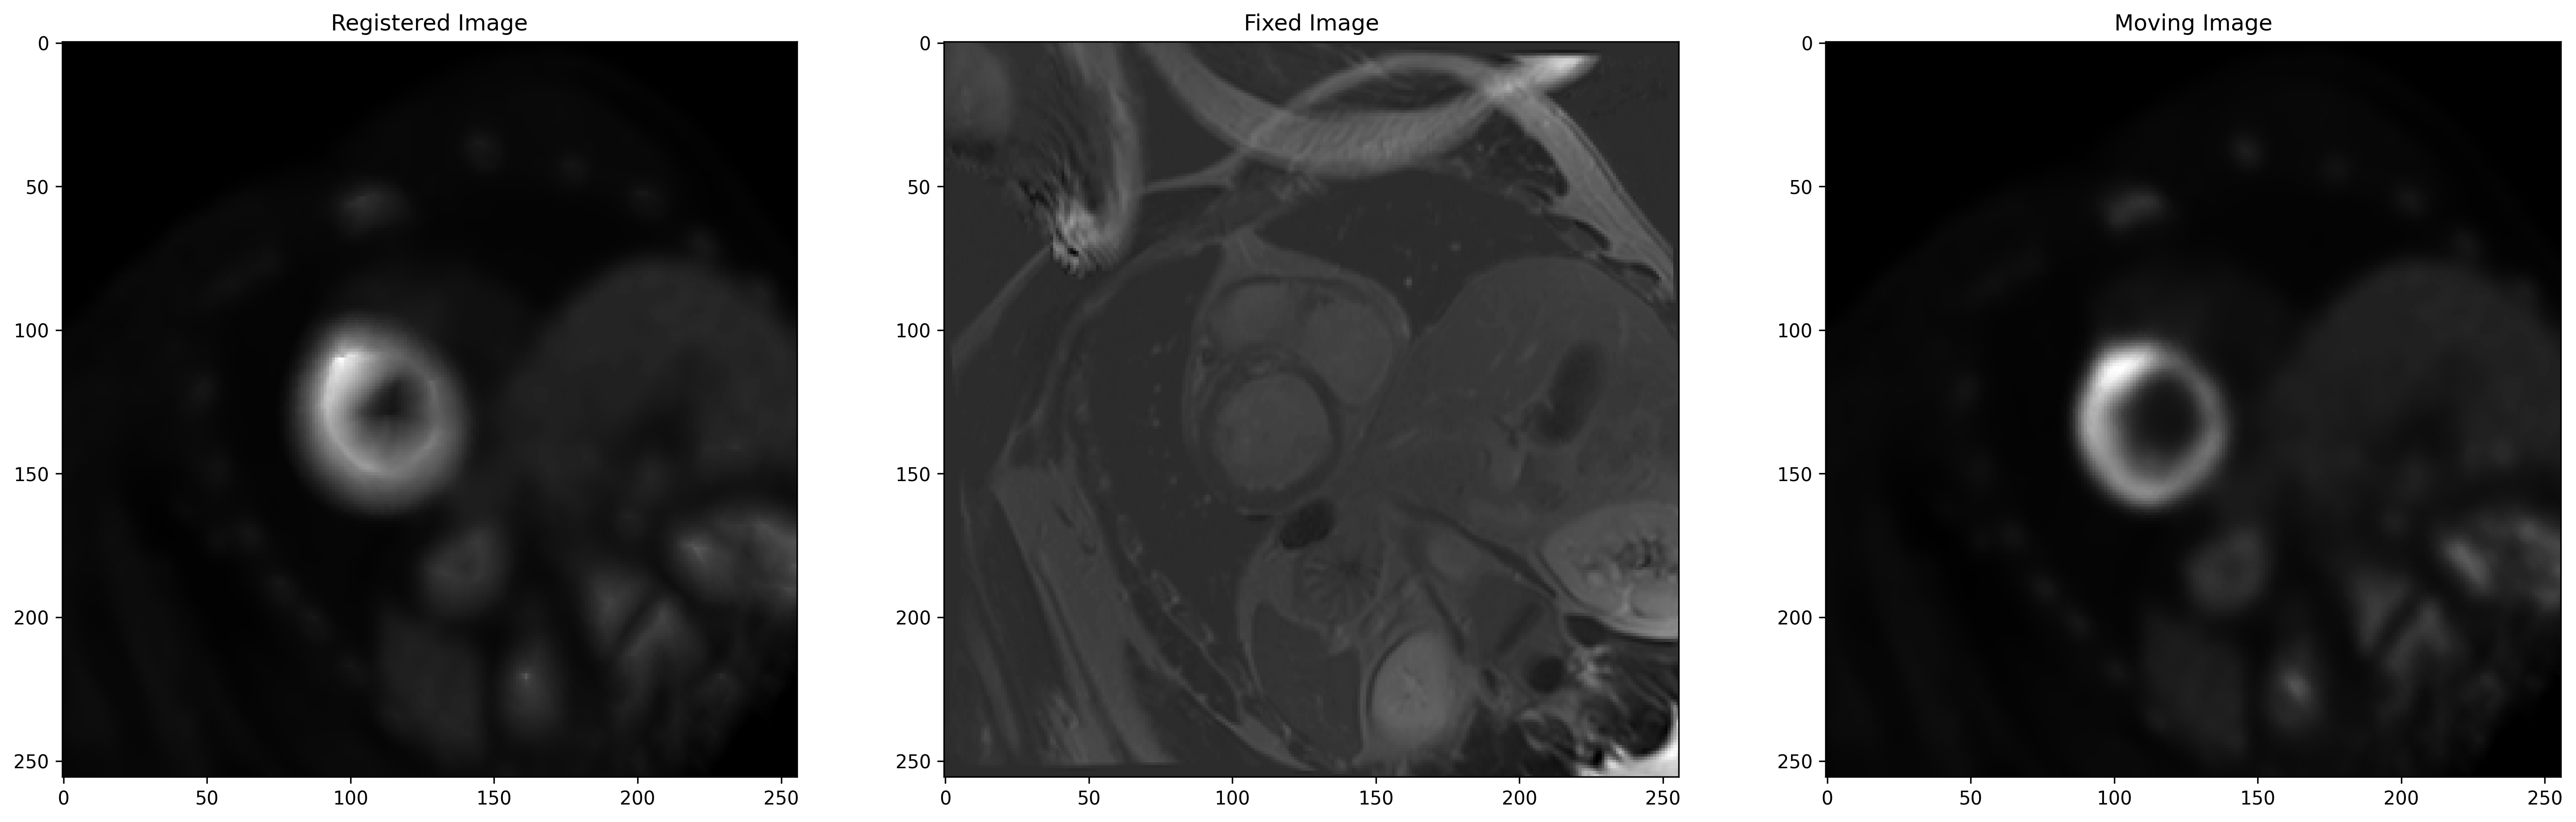

In [34]:
plt.figure(dpi=300,figsize=(24,8))

plt.subplot(1,3,1)
plt.imshow(val_registered_test[7].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,2)
plt.imshow(val_fixed_test[1].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,3)
plt.imshow(val_moving_test[1].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

In [23]:
def savebin(arr,name):
    gray_arr = (arr - arr.min()) * 255 / (arr.max() - arr.min())
    gray_arr = gray_arr.astype('uint8')
    gray_img = Image.fromarray(gray_arr, mode='L')
#     plt.imshow(gray_arr,cmap='gray')
#     plt.show()
    gray_img.save(name)

def saveRGB(arr,name):
    cv2.imwrite(name, arr, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

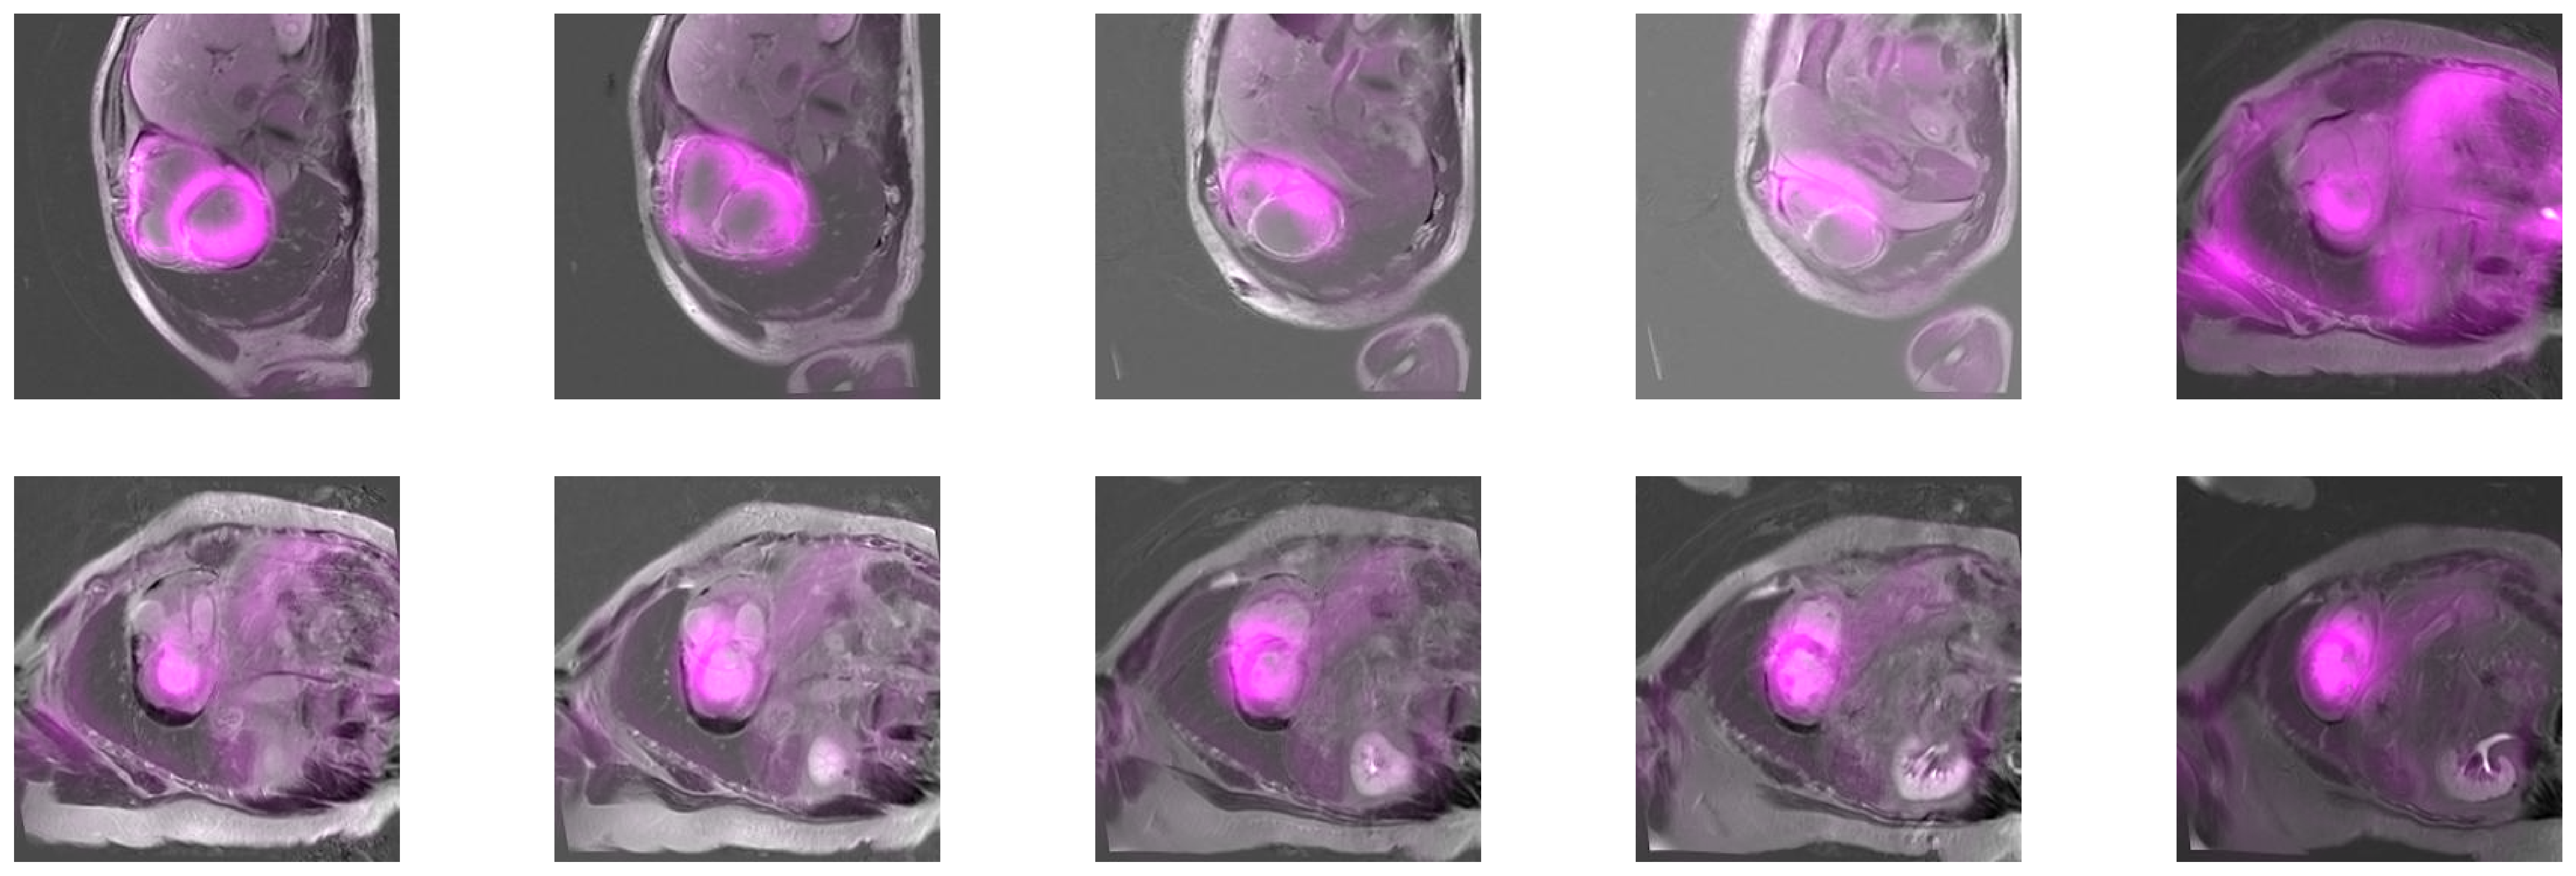

In [123]:
plt.figure(dpi=300,figsize=(24,8))
for i in range(1,11):
    reg=val_registered_train[i-1].cpu().data.numpy().squeeze()
    fix=val_fixed_train[i-1].cpu().data.numpy().squeeze()
    
    fix_path="./train_fix/"+str(i)+"_fixed_image_train.jpg"
    reg_path="./train_reg/"+str(i)+"_reg_image_train.jpg"
    
    savebin(fix,fix_path)
    saveRGB(reg,reg_path)
    
    # 读取第一幅图像
    img1 = cv2.imread(fix_path,cv2.IMREAD_GRAYSCALE)

    # 读取第二幅图像
    img2 = cv2.imread(reg_path,cv2.IMREAD_COLOR)

    height, width, _ = img2.shape
    img1 = cv2.resize(img1, (width, height))
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    
    # 将两幅图像以不同颜色叠加到一张新图上
    img = cv2.addWeighted(img1, 1, img2, 1.2, 0)

    # 将第一幅图像的像素值设为蓝色
    img[:, :, 1] = img1[:,:,1]

#     # 将第二幅图像的像素值设为绿色
#     img[:, :, 1] = img2[:, :, 1]

    # 显示新图像
    plt.subplot(2,5,i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

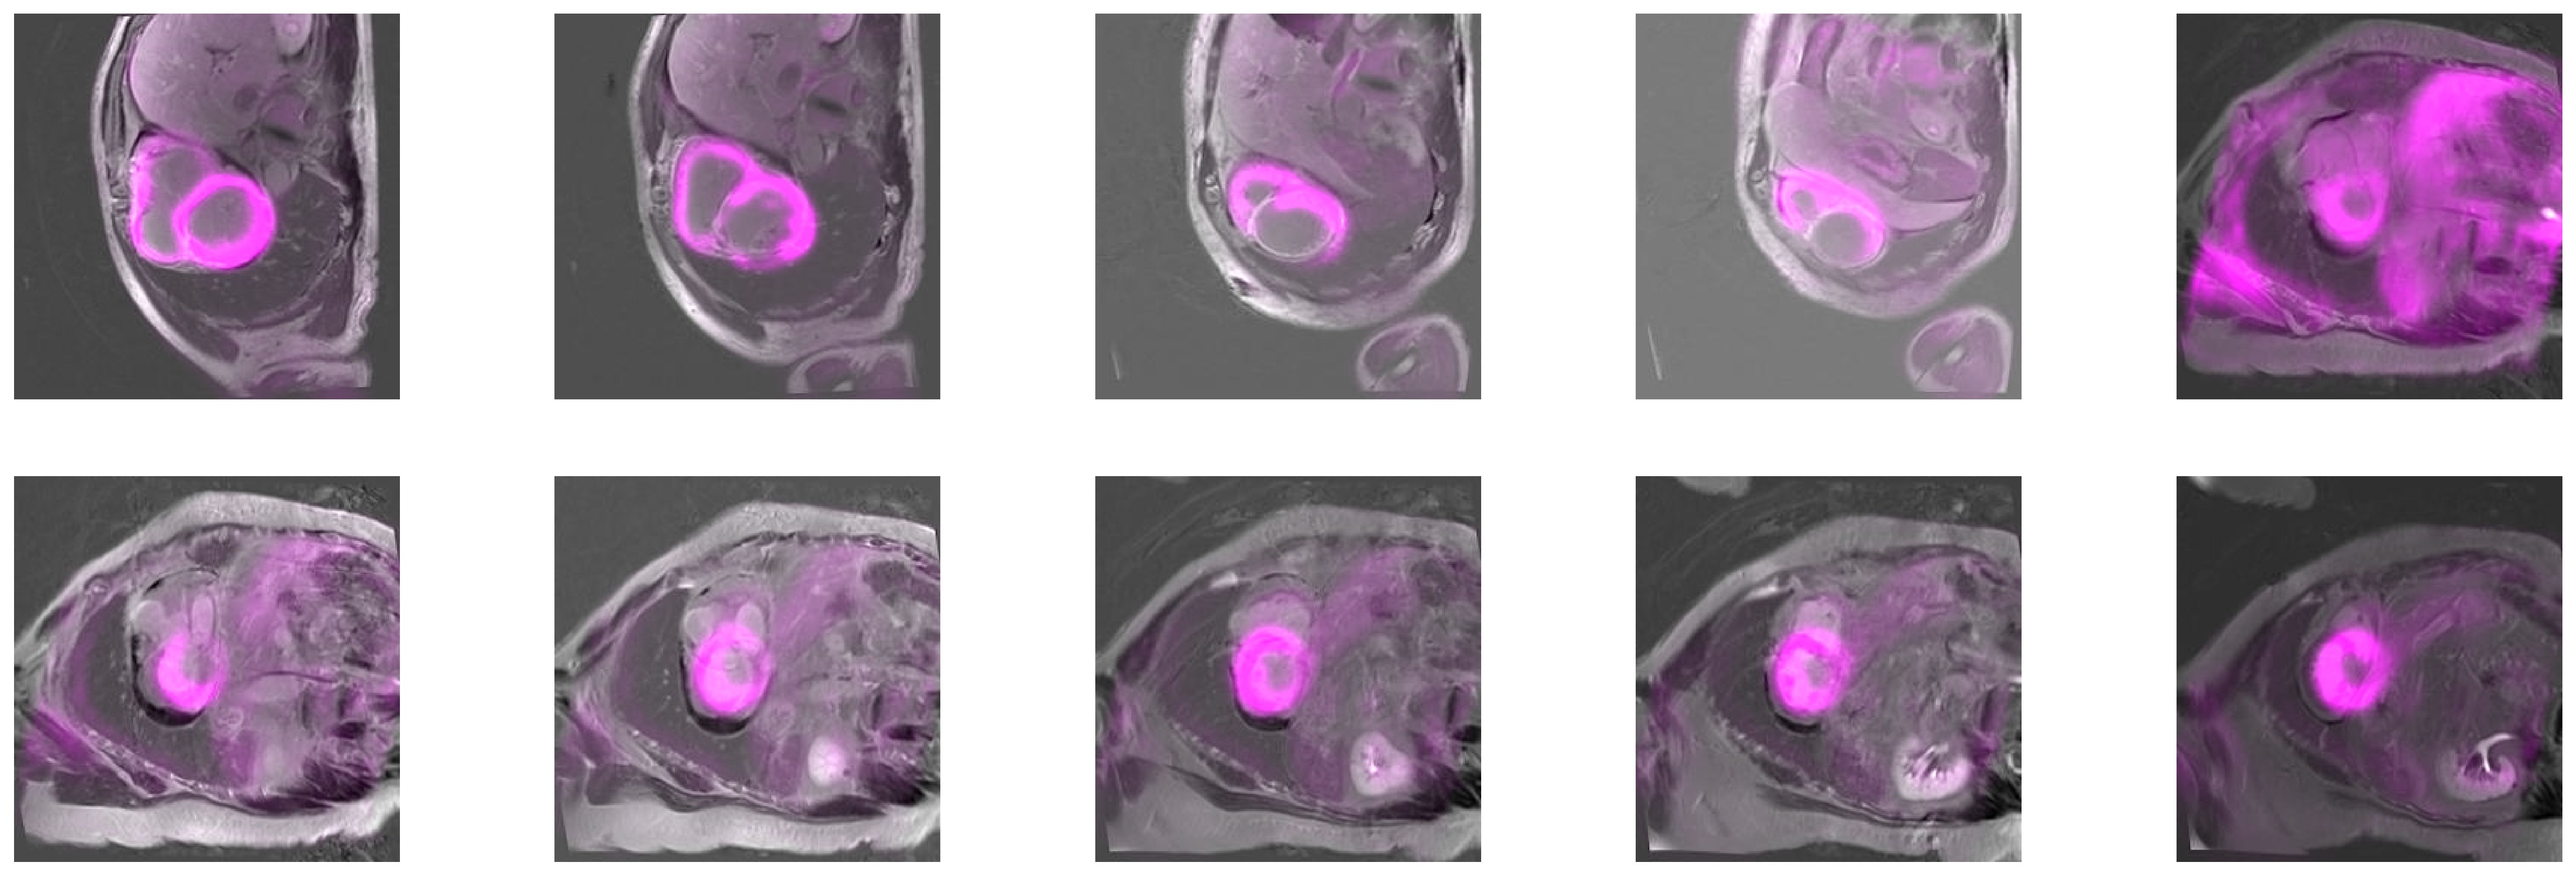

In [124]:
plt.figure(dpi=300,figsize=(24,8))
for i in range(1,11):
    moving=val_moving_train[i-1].cpu().data.numpy().squeeze()
    fix=val_fixed_train[i-1].cpu().data.numpy().squeeze()
    
    moving_path="./train_moving/"+str(i)+"_moving_image_train.jpg"
    fix_path="./train_fix/"+str(i)+"_fix_image_train.jpg"
    
    savebin(moving,moving_path)
    savebin(fix,fix_path)
    
    # 读取第一幅图像
    img1 = cv2.imread(fix_path,cv2.IMREAD_GRAYSCALE)

    # 读取第二幅图像
    img2 = cv2.imread(moving_path,cv2.IMREAD_COLOR)

    height, width, _ = img2.shape
    img1 = cv2.resize(img1, (width, height))
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    
    # 将两幅图像以不同颜色叠加到一张新图上
    img = cv2.addWeighted(img1, 1, img2, 1.2, 0)

    # 将第一幅图像的像素值设为蓝色
    img[:, :, 1] = img1[:,:,2]

    # # 将第二幅图像的像素值设为绿色
    # img[:, :, 1] = img2[:, :, 1]

    # 显示新图像
    plt.subplot(2,5,i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

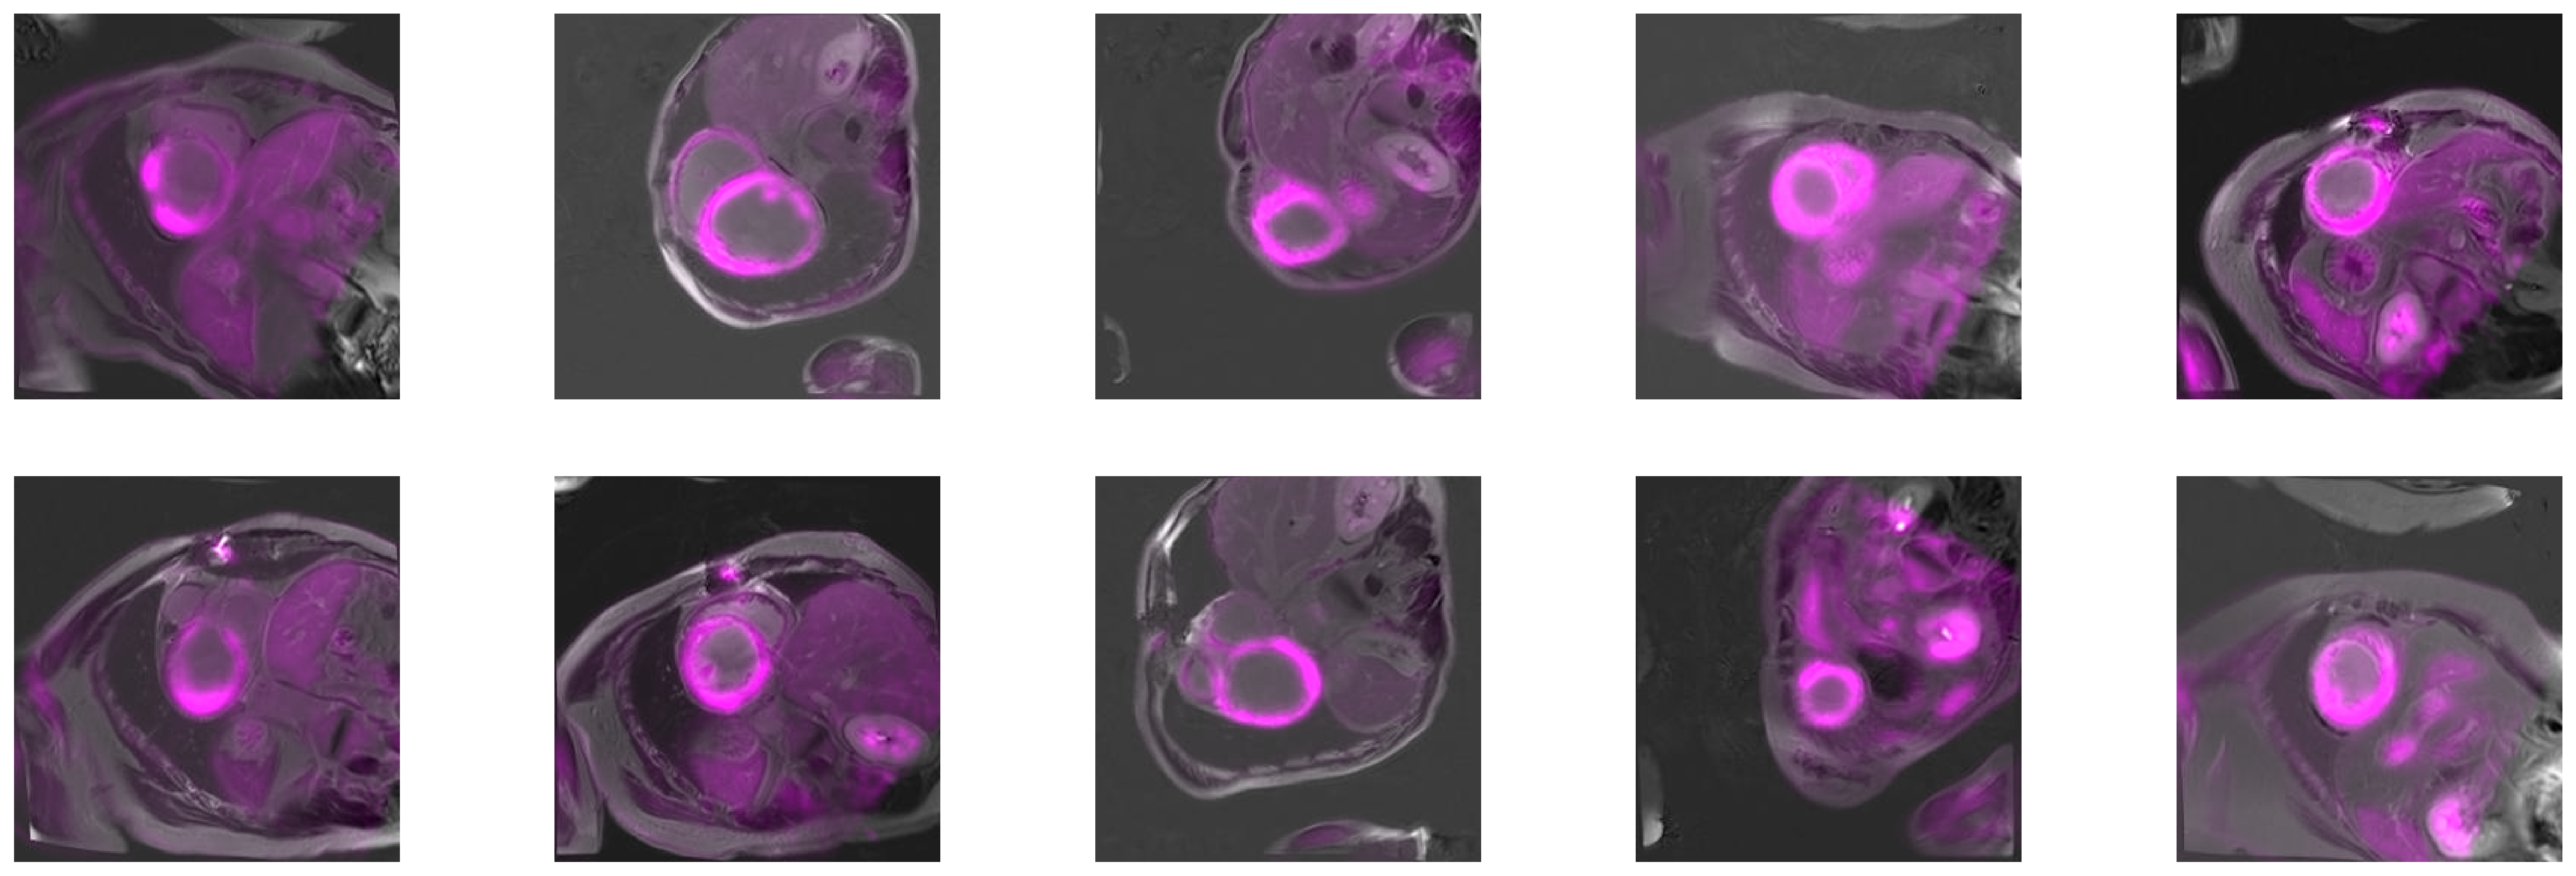

In [111]:
plt.figure(dpi=300,figsize=(24,8))
for i in range(1,11):
    moving=val_moving_test[i-1].cpu().data.numpy().squeeze()
    fix=val_fixed_test[i-1].cpu().data.numpy().squeeze()
    
    moving_path="./test_moving/"+str(i)+"_moving_image_test.jpg"
    fix_path="./test_fix/"+str(i)+"_fix_image_test.jpg"
    
    savebin(moving,moving_path)
    savebin(fix,fix_path)
    
    # 读取第一幅图像
    img1 = cv2.imread(fix_path,cv2.IMREAD_GRAYSCALE)

    # 读取第二幅图像
    img2 = cv2.imread(moving_path,cv2.IMREAD_COLOR)

    height, width, _ = img2.shape
    img1 = cv2.resize(img1, (width, height))
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    
    # 将两幅图像以不同颜色叠加到一张新图上
    img = cv2.addWeighted(img1, 1, img2, 1.2, 0)

    # 将第一幅图像的像素值设为蓝色
    img[:, :, 1] = img1[:,:,2]

    # # 将第二幅图像的像素值设为绿色
    # img[:, :, 1] = img2[:, :, 1]

    # 显示新图像
    plt.subplot(2,5,i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

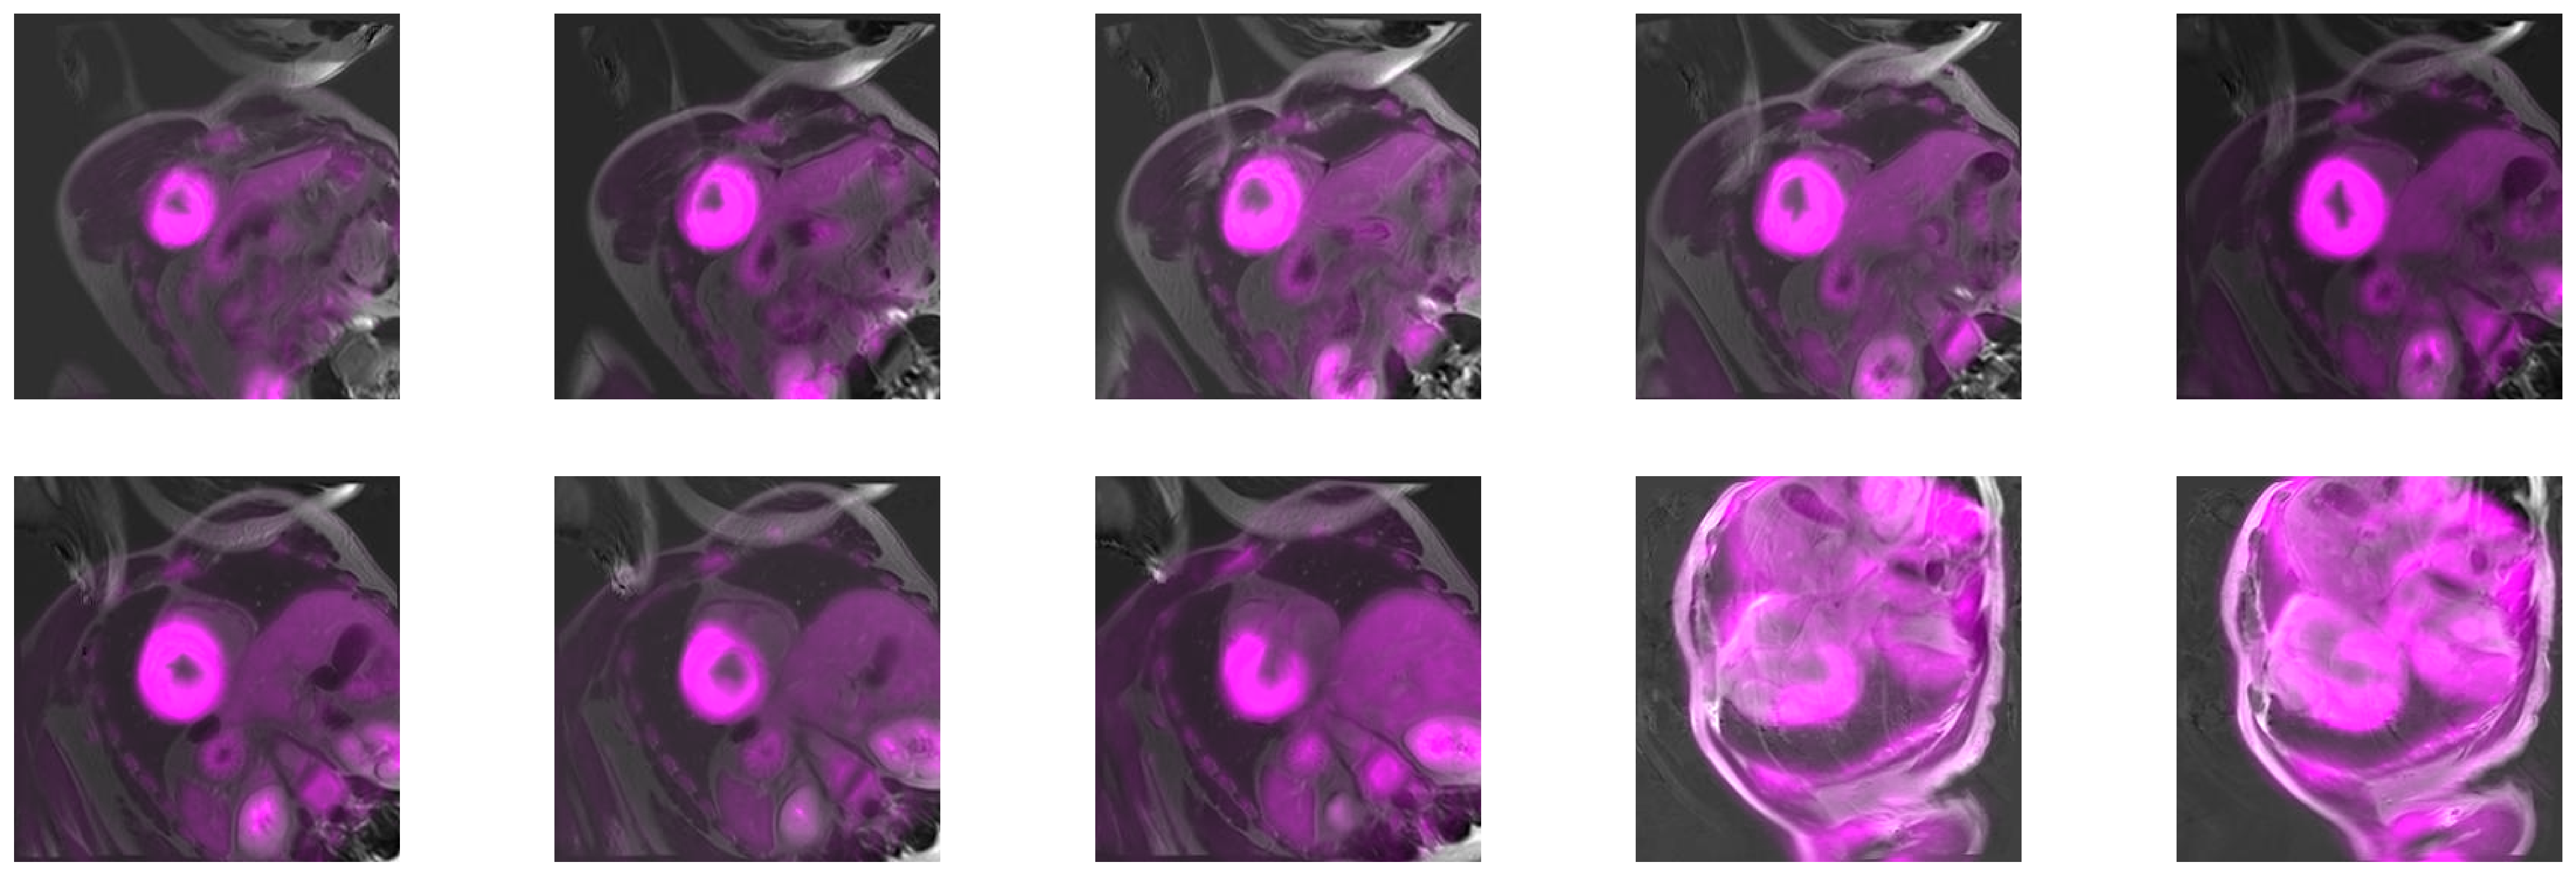

In [55]:
plt.figure(dpi=300,figsize=(24,8))
for i in range(1,11):
    reg=val_registered_test[i-1].cpu().data.numpy().squeeze()
    fix=val_fixed_test[i-1].cpu().data.numpy().squeeze()
    
    fix_path="./test_fix/"+str(i)+"_fixed_image_train.jpg"
    reg_path="./test_reg/"+str(i)+"_reg_image_train.jpg"
    
    savebin(fix,fix_path)
    savebin(reg,reg_path)
    
    # 读取第一幅图像
    img1 = cv2.imread(fix_path,cv2.IMREAD_GRAYSCALE)

    # 读取第二幅图像
    img2 = cv2.imread(reg_path,cv2.IMREAD_COLOR)

    height, width, _ = img2.shape
    img1 = cv2.resize(img1, (width, height))
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    
    # 将两幅图像以不同颜色叠加到一张新图上
    img = cv2.addWeighted(img1, 1, img2, 2, 0)

    # 将第一幅图像的像素值设为蓝色
    img[:, :, 1] = img1[:,:,2]

    # # 将第二幅图像的像素值设为绿色
    # img[:, :, 1] = img2[:, :, 1]

    # 显示新图像
    plt.subplot(2,5,i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")